# DSA 210
## Breaking the Myth: A Data-Driven Perspective of Immigration’s Impact on Criminal Activity 


CONTENT

Part 1: Preliminary Analysis
1) [Data Import](#1.-Data-Import)
2) [Data Pre-Processing](#2.-Data-Pre-Proceesing)
3) [Exploratory Data Analysis (EDA)](#3.-Exploratory-Data-Analysis)
4) Hypothesis Testing

[Part 2: Detailed Analysis](#part-2-detailed-analysis)

[Part 3: Data Enrichment](#part-3-data-enrichment)

[Part 3: ML Models](#part-3-machine-learning-odels)



### 1. Data Import

In [1]:
import pandas as pd

#Load CSV files
immigration_df=pd.read_excel('immigration_data.xlsx')
crime_df=pd.read_csv('crime_data.csv', delimiter=';')

### 2. Data Pre-Processing

In [2]:
immigration_df.head(3)

,Country,Immigration_percentage
0,AFRICA,1.9
1,Eastern Africa,1.7
2,Burundi,2.8


In [3]:
crime_df = crime_df.rename(columns={'CrimeIndex':'Crime_Rate'})
crime_df.head(3)

,flagCode,Country,Crime_Rate,Safety
0,VE,Venezuela,81.2,18.8
1,PG,Papua New Guinea,79.7,20.3
2,AF,Afghanistan,78.3,21.7


In [4]:
print("Immigration Countries:", immigration_df['Country'].nunique())
print("Crime Countries:", crime_df['Country'].nunique())

Immigration Countries: 262
Crime Countries: 141


In [5]:
print(set(immigration_df['Country']).difference(set(crime_df['Country'])))

{'Lesotho', 'Eswatini', 'Democratic Republic of the Congo', 'Grenada', 'Mali', 'Samoa', 'Burkina Faso', 'Curaçao*', 'Eastern Europe', 'Viet Nam', 'Southern Europe', 'Bonaire, Sint Eustatius and Saba*', 'Saint Pierre and Miquelon*', 'Aruba*', 'Montserrat*', 'Isle of Man*', 'Equatorial Guinea', 'Gibraltar*', 'Faroe Islands*', 'Seychelles', 'Guinea-Bissau', 'Holy See*', 'Saint Kitts and Nevis', 'Eastern Asia', 'Cayman Islands*', 'Australia/New Zealand', 'South-Eastern Asia', 'Guam*', 'Benin', "Côte d'Ivoire", 'South Sudan', 'Western Asia', 'Turks and Caicos Islands*', 'Gabon', 'South America', 'Chad', 'United Kingdom*', 'Bolivia (Plurinational State of)', 'Cabo Verde', 'LATIN AMERICA AND THE CARIBBEAN', 'Liechtenstein', 'Czechia', 'Dominica', 'Saint Vincent and the Grenadines', 'Middle Africa', 'Micronesia', 'Western Africa', 'Malawi', 'Iran (Islamic Republic of)', 'Senegal', 'Norway*', 'Northern Mariana Islands*', 'Ukraine*', 'Timor-Leste', 'Burundi', 'Palau', 'Mayotte', 'Kiribati', 'Ton

We can see here that some country names have nonalphabetical characters. For example, even though Denmark exists in crime data it doesn't match to immigration data country because it is written as 'Denmark*'. Therefore we should drop nonalphabetic characters. 

In [6]:
import re

# Define a cleaning function
def clean_country_name(name):
    return re.sub(r'[^a-zA-Z\s]', '', name).strip()

# Apply to both dataframes
immigration_df['Country'] = immigration_df['Country'].apply(clean_country_name)
crime_df['Country'] = crime_df['Country'].apply(clean_country_name)

In [7]:
print(set(immigration_df['Country']).difference(set(crime_df['Country'])))


{'Lesotho', 'Eswatini', 'Saint Martin French part', 'Democratic Republic of the Congo', 'Polynesia', 'Grenada', 'Mali', 'Samoa', 'Burkina Faso', 'Eastern Europe', 'Viet Nam', 'Channel Islands', 'Southern Europe', 'Tokelau', 'Gibraltar', 'Republic of Moldova', 'Dem Peoples Republic of Korea', 'Greenland', 'Equatorial Guinea', 'Seychelles', 'Saint Kitts and Nevis', 'Trkiye', 'Eastern Asia', 'American Samoa', 'Benin', 'Saint Pierre and Miquelon', 'South Sudan', 'Western Asia', 'French Guiana', 'Gabon', 'United States Virgin Islands', 'South America', 'Chad', 'Cayman Islands', 'Cte dIvoire', 'Cabo Verde', 'LATIN AMERICA AND THE CARIBBEAN', 'Liechtenstein', 'Czechia', 'Dominica', 'Curaao', 'Bonaire Sint Eustatius and Saba', 'Saint Vincent and the Grenadines', 'Middle Africa', 'Micronesia', 'Western Africa', 'Malawi', 'Turks and Caicos Islands', 'Wallis and Futuna Islands', 'Senegal', 'Burundi', 'Palau', 'Mayotte', 'Martinique', 'Kiribati', 'Tonga', 'Bermuda', 'AFRICA', 'TimorLeste', 'Isle o

Dropping nonalphabetic characters is not enough to match the countries because naming conventions are different for example 'Russian Federation' in immigration data corrseponds to 'Russia' in crime rate data. Python has a package called country_converter which standardizes all country names to a common format. I used this package to ensure consistent country naming across datasets and to merge them.


Country_converter throws warnings for strings that are not actual country names such as region names or recent political changes like 'Trkiye' instead of 'Turkey' existing in dataset immigration_df. I included a list of regions to exclude and a list of correct names.

In [8]:
import country_converter as coco
def standardize_country_names(df, country_col='Country'):
    # Define region names to exclude
    regions_to_exclude = [
        "AFRICA", "ASIA", "EUROPE", "OCEANIA", "LATIN AMERICA AND THE CARIBBEAN", "NORTHERN AMERICA",
        "Western Europe", "Eastern Europe", "Southern Europe", "Northern Europe",
        "Eastern Asia", "Southern Asia", "SouthEastern Asia", "Central Asia", "Western Asia",
        "Middle Africa", "Eastern Africa", "Western Africa", "Northern Africa",
        "Central America", "South America", "Caribbean",
        "Melanesia", "Polynesia",
        "Channel Islands", "AustraliaNew Zealand", "More than one regular expression match for AustraliaNew Zealand"
    ]

    # Drop region-like rows
    df = df[~df[country_col].isin(regions_to_exclude)].copy()

    # Fix specific naming issues
    name_corrections = {
        "Trkiye": "Turkey",
        "China Taiwan Province of China": "Taiwan",
        "AustraliaNew Zealand": "Australia",
        "Curaao": "Curacao",
        "Runion": "Reunion",
        "Scotland (NUTS 2021)": "Scotland",
        "Northern Ireland (UK) (NUTS 2021)": "Northern Ireland"
    }
    df[country_col] = df[country_col].replace(name_corrections)

    # Preprocess names to remove unwanted text (e.g., NUTS 2021, UK) 
    # You can further customize if needed
    df[country_col] = df[country_col].apply(lambda x: re.sub(r"\s*\(.*\)", "", x))

    # Standardize country names
    df['Country_standardized'] = coco.convert(
        names=df[country_col], to='name_short', not_found=""
    )

    return df


In [9]:
immigration_df = standardize_country_names(immigration_df)
crime_df = standardize_country_names(crime_df)

In [10]:
immigration_df.head()

,Country,Immigration_percentage,Country_standardized
2,Burundi,2.8,Burundi
3,Comoros,1.4,Comoros
4,Djibouti,10.8,Djibouti
5,Eritrea,0.4,Eritrea
6,Ethiopia,0.9,Ethiopia


In [11]:
crime_df.head()

,flagCode,Country,Crime_Rate,Safety,Country_standardized
0,VE,Venezuela,81.2,18.8,Venezuela
1,PG,Papua New Guinea,79.7,20.3,Papua New Guinea
2,AF,Afghanistan,78.3,21.7,Afghanistan
3,HT,Haiti,77.9,22.1,Haiti
4,ZA,South Africa,75.4,24.6,South Africa


In [12]:
merged_df = pd.merge(immigration_df, crime_df, on='Country_standardized', how='outer')


An outer merge is used to combine all rows from two datasets, regardless of whether they have matching keys. This means that if a record exists in only one of the dataframes, it will still appear in the merged result, with missing values (NaN) filled in for the columns from the other dataframe.
Bu using outer merge, we ensure too keep all the data and not lose anything during merge, which is useful for data exploration and missing value detection. 

In [13]:
merged_df.head()

,Country_x,Immigration_percentage,Country_standardized,flagCode,Country_y,Crime_Rate,Safety
0,Burundi,2.8,Burundi,NaN,NaN,NaN,NaN
1,Comoros,1.4,Comoros,NaN,NaN,NaN,NaN
2,Djibouti,10.8,Djibouti,NaN,NaN,NaN,NaN
3,Eritrea,0.4,Eritrea,NaN,NaN,NaN,NaN
4,Ethiopia,0.9,Ethiopia,ET,Ethiopia,50.8,49.2


In [14]:
# Rearrange the stucture of the dataframe
# Drop unwanted columns
merged_df.drop(['Country_x', 'Country_y', 'Safety'], axis=1, inplace=True)

# Rename 'Country_standardized' to 'Country' and move it to the front
merged_df.rename(columns={'Country_standardized': 'Country'}, inplace=True)
cols = merged_df.columns.tolist()
cols.insert(0, cols.pop(cols.index('Country')))
merged_df = merged_df[cols]

# Check the updated DataFrame
print(merged_df.head())


    Country  Immigration_percentage flagCode  Crime_Rate
0   Burundi                     2.8      NaN         NaN
1   Comoros                     1.4      NaN         NaN
2  Djibouti                    10.8      NaN         NaN
3   Eritrea                     0.4      NaN         NaN
4  Ethiopia                     0.9       ET        50.8


### 3. Exploratory Data Analysis

In [15]:
#Data Shape
merged_df.shape

(236, 4)

In [16]:
merged_df.dtypes

Country                    object
Immigration_percentage    float64
flagCode                   object
Crime_Rate                float64
dtype: object

Observations:
*Concentration at Low Immigration Percentage:
Data points 

In [17]:
merged_df.isnull().sum()

Country                    0
Immigration_percentage     2
flagCode                  95
Crime_Rate                94
dtype: int64

In [18]:
merged_df.isnull().sum()/len(merged_df)

Country                   0.000000
Immigration_percentage    0.008475
flagCode                  0.402542
Crime_Rate                0.398305
dtype: float64

-->High percentage of missing values in crime index column.

Statistics

In [19]:
merged_df.describe()

,Immigration_percentage,Crime_Rate
count,234.000000,142.000000
mean,15.091880,45.865493
std,19.851984,15.459891
min,0.000000,12.900000
25%,1.725000,32.950000
50%,6.400000,46.450000
75%,18.425000,56.125000
max,100.000000,81.200000


Let's see how much the missing values of crime index affects the results. 

In [20]:
df_cleaned=merged_df.dropna(axis=0, how='any', inplace=False)


In [21]:
df_cleaned.describe()

,Immigration_percentage,Crime_Rate
count,141.000000,141.000000
mean,11.602128,45.737589
std,15.786013,15.439423
min,0.000000,12.900000
25%,1.500000,32.800000
50%,5.300000,46.400000
75%,14.400000,55.300000
max,76.700000,81.200000


In [22]:
(merged_df['Immigration_percentage'].mean() - df_cleaned['Immigration_percentage'].mean())/merged_df['Immigration_percentage'].mean()

0.23123378951141838

Missing values change the mean of immigration percentage by 23%.

In [23]:
import numpy as np
np.corrcoef(merged_df['Immigration_percentage'],merged_df['Crime_Rate'])

array([[nan, nan],
       [nan, nan]])

We cannot calculate correlation because of the missing values. 

In [24]:
np.corrcoef(df_cleaned['Immigration_percentage'],df_cleaned['Crime_Rate'])

array([[ 1.        , -0.50337572],
       [-0.50337572,  1.        ]])

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

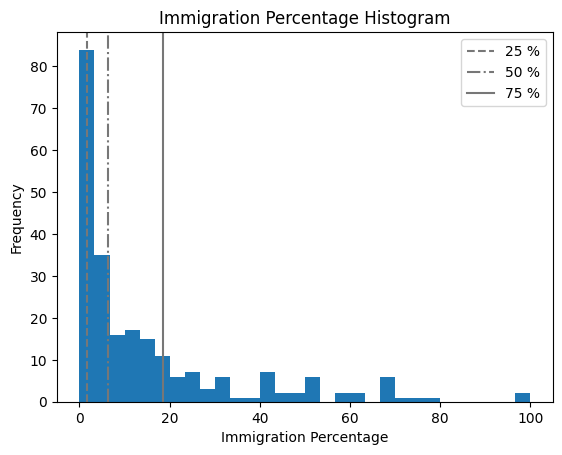

In [26]:
plt.hist(merged_df['Immigration_percentage'],bins=30)
q1=np.nanpercentile(merged_df['Immigration_percentage'],25)
q2=np.nanpercentile(merged_df['Immigration_percentage'],50)
q3=np.nanpercentile(merged_df['Immigration_percentage'],75)
plt.axvline(q1,color='#777777',linestyle='dashed',label='25 %')
plt.axvline(q2,color='#777777',linestyle='dashdot',label='50 %')
plt.axvline(q3,color='#777777',linestyle='solid',label='75 %')
plt.legend(loc='upper right')
plt.xlabel('Immigration Percentage')
plt.ylabel('Frequency')
plt.title('Immigration Percentage Histogram')
plt.savefig('immigration_histogram.png')
plt.show()

Observations:
1. Highly skewed distribution: The data is heavily right-skewed, indicating that most countries have low immigration percentages.
2. Long tail: There are some countries with very high immigration percentages, which are potential outliers.

Outlier Detection 

                               Country  Immigration_percentage
9                              Mayotte                    44.0
66                               Macau                    59.3
88                           Singapore                    48.7
94                             Bahrain                    52.3
99                              Jordan                    45.7
100                             Kuwait                    67.3
103                              Qatar                    76.7
108               United Arab Emirates                    74.0
126                        Isle of Man                    51.9
133                            Andorra                    59.1
138                            Vatican                   100.0
152                      Liechtenstein                    69.4
153                         Luxembourg                    51.2
154                             Monaco                    70.2
159                              Aruba                 

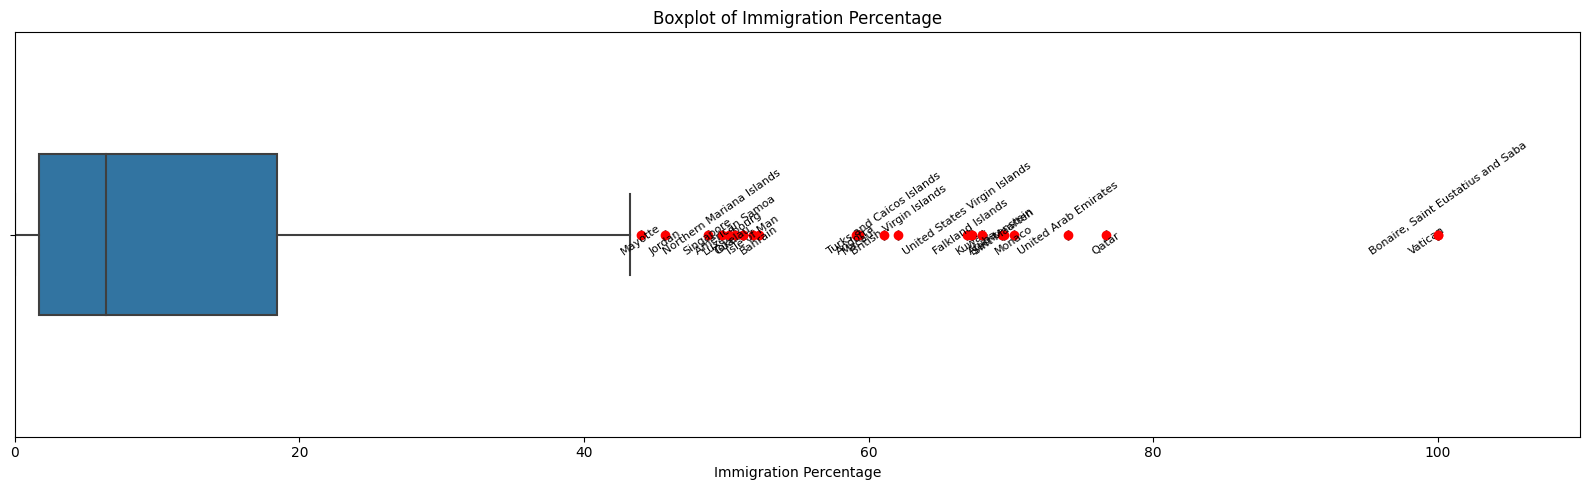

In [27]:
# Step 1: Calculate IQR to find outliers
Q1 = merged_df['Immigration_percentage'].quantile(0.25)
Q3 = merged_df['Immigration_percentage'].quantile(0.75)
IQR = Q3 - Q1
outlier_threshold = Q3 + 1.5 * IQR

# Step 2: Filter outliers
outliers = merged_df[merged_df['Immigration_percentage'] > outlier_threshold].copy()
print(outliers[['Country', 'Immigration_percentage']])

# Step 3: Create the boxplot
plt.figure(figsize=(16, 5))
sns.boxplot(x=merged_df['Immigration_percentage'], width=0.4)
plt.title('Boxplot of Immigration Percentage')
plt.xlabel('Immigration Percentage')

# Step 4: Adjust overlapping labels
x_counts = outliers['Immigration_percentage'].value_counts()
dup_values = x_counts[x_counts > 1].index.tolist()

for i, (_, row) in enumerate(outliers.iterrows()):
    x = row['Immigration_percentage']
    y = 0
    label = row['Country']

    # Slight offset if this x value appears more than once
    if x in dup_values:
        offset = (i % 2) * 1.5 - 0.75  # alternate left/right: -0.75, +0.75
        x_display = x + offset
    else:
        x_display = x

    plt.scatter(x, y, color='red', zorder=3)
    plt.text(x_display, 0.05, label,
             rotation=35, ha='center', fontsize=8)

plt.xlim(0, outliers['Immigration_percentage'].max() + 10)
plt.tight_layout()
plt.savefig('immigration_boxplot.png')
plt.show()


As seen abpve  Bonaire, Saint Eustatius and Saba  and Vatican has 100% immigration percentage. It is due to how immigration percentage is calculated. It refers to the ratio of number of immigrants to the total poulation. Bonaire, Saint Eustatius and Saba and Vatican has small population but high proportion of foreign born residents, creating this statistical effect.

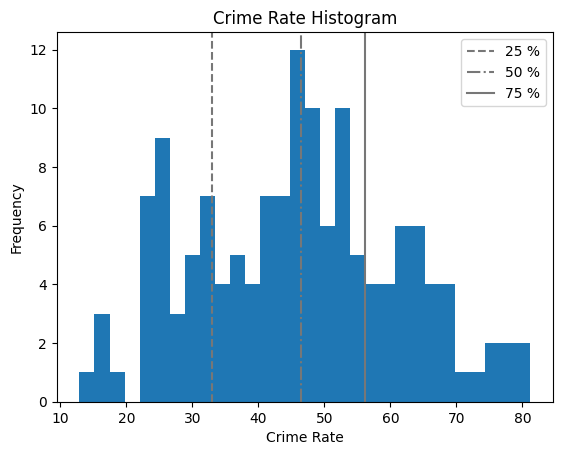

In [28]:
plt.hist(merged_df['Crime_Rate'],bins=30)
q1=np.nanpercentile(merged_df['Crime_Rate'],25)
q2=np.nanpercentile(merged_df['Crime_Rate'],50)
q3=np.nanpercentile(merged_df['Crime_Rate'],75)
plt.axvline(q1,color='#777777',linestyle='dashed',label='25 %')
plt.axvline(q2,color='#777777',linestyle='dashdot',label='50 %')
plt.axvline(q3,color='#777777',linestyle='solid',label='75 %')
plt.legend(loc='upper right')
plt.xlabel('Crime Rate')
plt.ylabel('Frequency')
plt.title('Crime Rate Histogram')
plt.savefig('crime_histogram.png')
plt.show()

Observations:
1. Rougly symmetrical distribution: The data appears more balanced with less skewness. 


No crime rate outliers detected.


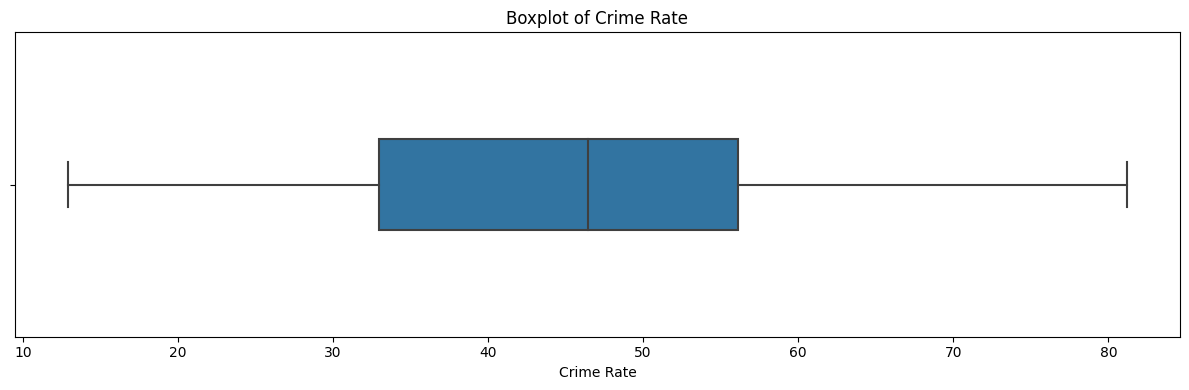

In [29]:
plt.figure(figsize=(12, 4))
sns.boxplot(x=merged_df['Crime_Rate'], width=0.3)
plt.title('Boxplot of Crime Rate')
plt.xlabel('Crime Rate')

# Calculate IQR for crime rate
Q1 = merged_df['Crime_Rate'].quantile(0.25)
Q3 = merged_df['Crime_Rate'].quantile(0.75)
IQR = Q3 - Q1
crime_outlier_threshold = Q3 + 1.5 * IQR

# Filter out outliers
crime_outliers = merged_df[merged_df['Crime_Rate'] > crime_outlier_threshold]


if not crime_outliers.empty:
    # Plot and annotate outlier points
    for _, row in crime_outliers.iterrows():
        plt.scatter(row['Crime_Rate'], 0, color='red', zorder=3)
        plt.text(row['Crime_Rate'], 0.05, row['Country_standardized'],
                 fontsize=8, rotation=45, ha='left', va='bottom')

    # Extend x-axis to avoid clipping
    max_val = crime_outliers['Crime_Rate'].max()
    plt.xlim(0, max_val + 5)
else:
    # Optional: Print a message if no outliers
    print("No crime rate outliers detected.")

plt.tight_layout()
plt.savefig('crime_boxplot.png')
plt.show()


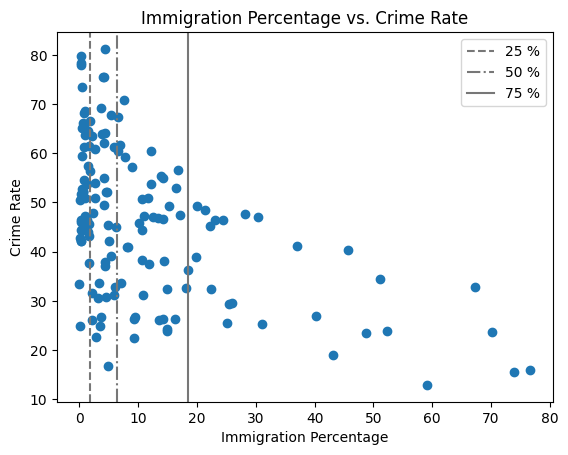

In [30]:
plt.scatter(merged_df['Immigration_percentage'],merged_df['Crime_Rate'])

q1=np.nanpercentile(merged_df['Immigration_percentage'],25)
q2=np.nanpercentile(merged_df['Immigration_percentage'],50)
q3=np.nanpercentile(merged_df['Immigration_percentage'],75)
plt.axvline(q1,color='#777777',linestyle='dashed',label='25 %')
plt.axvline(q2,color='#777777',linestyle='dashdot',label='50 %')
plt.axvline(q3,color='#777777',linestyle='solid',label='75 %')
plt.legend(loc='upper right')


plt.title('Immigration Percentage vs. Crime Rate')
plt.xlabel('Immigration Percentage')
plt.ylabel('Crime Rate')
plt.savefig('immigration_vs_crime.png')
plt.show()


Observations:
1. Overall Trend: There appears to be no clear linear correlation between immigration percentage and crime rate. 
2. Clustering: Most counctries cluster in the low immigration(0-10%) and moderate crime rate zone. 

While the initial goal of this project was to conduct a global analysis, early exploration of the data revealed that certain countries — particularly in South America and some tropical regions — exhibit extremely high crime rates despite having relatively low immigration levels. Including these countries in the main analysis could misrepresent or obscure the relationship under investigation, as their crime rates are likely driven by more fundamental issues such as political instability, organized crime, poverty, and weak judicial institutions. These underlying factors act as confounders, making it difficult to isolate the effect of immigration on crime. To ensure a more valid and interpretable analysis, this study will focus on European countries, which tend to have more comparable economic conditions, better institutional structures, and more consistent crime and immigration reporting standards. By narrowing the scope in this way, the project reduces external variability and increases the likelihood of uncovering meaningful patterns specific to the immigration-crime dynamic, rather than broader structural issues that dominate in less stable regions.

In [31]:
# List of European countries using ISO Alpha-2 codes
europe_iso2 = [
    'AL', 'AD', 'AT', 'BY', 'BE', 'BA', 'BG', 'HR', 'CY', 'CZ',
    'DK', 'EE', 'FI', 'FR', 'DE', 'GR', 'HU', 'IS', 'IE', 'IT',
    'XK', 'LV', 'LI', 'LT', 'LU', 'MT', 'MD', 'MC', 'ME', 'NL',
    'MK', 'NO', 'PL', 'PT', 'RO', 'RU', 'SM', 'RS', 'SK', 'SI',
    'ES', 'SE', 'CH', 'UA', 'GB', 'VA'
]

In [32]:
import country_converter as coco

def filter_by_iso2(df, country_col='Country', flag_col='flagCode'):
    """
    Filters the DataFrame based on a list of ISO2 country codes and adds flag codes (ISO2) to the DataFrame.

    Parameters:
    df (pandas DataFrame): The DataFrame to filter.
    iso2_codes (list): The list of ISO2 country codes to filter by.
    country_col (str): The name of the column containing the country names (default is 'Country').
    flag_col (str): The name of the column to store the flag codes (default is 'flagCode').

    Returns:
    pandas DataFrame: Filtered DataFrame with only the rows having flag codes in iso2_codes.
    """
    # Add flag codes to the DataFrame by mapping the country names to flag codes
    df[flag_col] = coco.convert(names=df[country_col], to='ISO2')

    # Filter the DataFrame based on the ISO2 codes
    filtered_df = df[df[flag_col].isin(europe_iso2)].copy()

    return filtered_df


In [33]:
european_df=merged_df[merged_df['flagCode'].isin(europe_iso2)]
european_df.head()

,Country,Immigration_percentage,flagCode,Crime_Rate
95,Cyprus,14.9,CY,32.4
110,Belarus,11.6,BY,50.8
111,Bulgaria,4.4,BG,37.1
112,Czechia,9.5,CZ,26.8
113,Hungary,7.1,HU,33.7


Descriptive Statistics for Europe

In [34]:
european_df.describe()

,Immigration_percentage,Crime_Rate
count,41.000000,41.000000
mean,17.297561,35.736585
std,14.444298,9.503361
min,1.700000,12.900000
25%,9.200000,26.800000
50%,14.200000,34.400000
75%,19.800000,45.100000
max,70.200000,55.300000


In [35]:
european_df.isnull().sum()

Country                   0
Immigration_percentage    0
flagCode                  0
Crime_Rate                0
dtype: int64

Explanatory Data Analysis for Europe

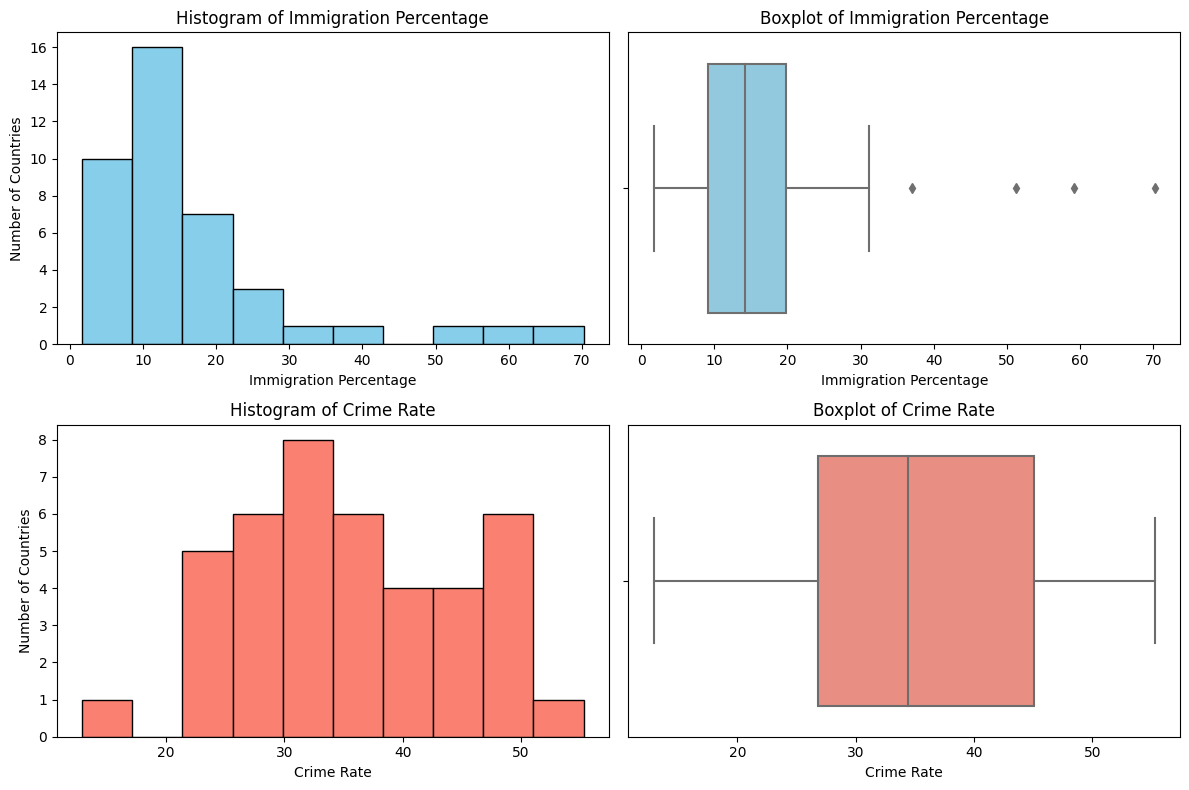

In [36]:
plt.figure(figsize=(12, 8))  # Adjust figure size

# Immigration Histogram (top-left)
plt.subplot(2, 2, 1)
plt.hist(european_df['Immigration_percentage'], bins=10, color='skyblue', edgecolor='black')
plt.title('Histogram of Immigration Percentage')
plt.xlabel('Immigration Percentage')
plt.ylabel('Number of Countries')

# Immigration Boxplot (top-right)
plt.subplot(2, 2, 2)
sns.boxplot(x=european_df['Immigration_percentage'], color='skyblue')
plt.title('Boxplot of Immigration Percentage')
plt.xlabel('Immigration Percentage')

# Crime Histogram (bottom-left)
plt.subplot(2, 2, 3)
plt.hist(european_df['Crime_Rate'], bins=10, color='salmon', edgecolor='black')
plt.title('Histogram of Crime Rate')
plt.xlabel('Crime Rate')
plt.ylabel('Number of Countries')

# Crime Boxplot (bottom-right)
plt.subplot(2, 2, 4)
sns.boxplot(x=european_df['Crime_Rate'], color='salmon')
plt.title('Boxplot of Crime Rate')
plt.xlabel('Crime Rate')

plt.tight_layout()
plt.savefig('europe.png')
plt.show()


In [37]:
# Step 1: Calculate IQR
Q1 = european_df['Immigration_percentage'].quantile(0.25)
Q3 = european_df['Immigration_percentage'].quantile(0.75)
IQR = Q3 - Q1
threshold = Q3 + 1.5 * IQR

# Step 2: Filter outliers
immigration_outliers = european_df[european_df['Immigration_percentage'] > threshold]

# Step 3: Display them
print("Immigration Outliers (based on IQR method):")
print(immigration_outliers[['Country', 'Immigration_percentage']])


Immigration Outliers (based on IQR method):
        Country  Immigration_percentage
133     Andorra                    59.1
140       Malta                    37.0
153  Luxembourg                    51.2
154      Monaco                    70.2


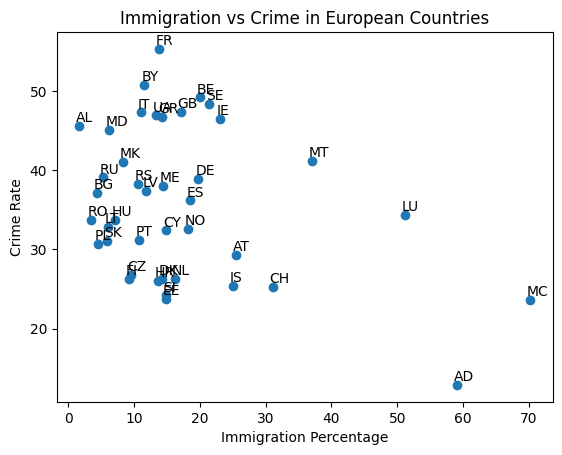

In [38]:
plt.scatter('Immigration_percentage','Crime_Rate',data=european_df)
# Add country codes as labels to each point
for i, row in european_df.iterrows():
    plt.text(row['Immigration_percentage']-0.5, row['Crime_Rate']+0.5, row['flagCode'], )

plt.xlabel('Immigration Percentage')
plt.ylabel('Crime Rate')
plt.title('Immigration vs Crime in European Countries')
plt.savefig('scatter_europe.png')
plt.show()

### 4. Hypothesis Testing

In [39]:
import numpy as np

In [40]:
np.corrcoef(european_df['Immigration_percentage'],european_df['Crime_Rate'])

array([[ 1.        , -0.33574244],
       [-0.33574244,  1.        ]])

In [41]:
from scipy.stats import spearmanr
spearmanr(european_df['Immigration_percentage'],european_df['Crime_Rate'])

SignificanceResult(statistic=-0.1742919389978213, pvalue=0.2757712339515884)

To evaluate whether there is a relationship between immigration levels and crime rates, I divided the countries into distinct groups based on their immigration percentages as low, medium, and high immigration using quantiles (tertiles for 3 groups). This method allows us to search for potential non-linear patterns beyond linear relationships we can observe with pearson or spearman correlation coefficients. Using tertiles also ensures that each group contains roughly equal number of observations, which improves the comprability of statistical analyses. By applying ANOVA, I can statistically test whether the differences in crime indices across these groups are significant, thereby providing a clearer understanding of the impact of immigration on crime.



ANOVA Hypothesis testing\
Null Hypothesis: Immigration percentage does not have an effect on the crime index.\
Alternative Hypothesis: There is at least one group whose mean crime index is significantly different from others. 


In [42]:
# Divide into tertiles (3 roughly equal groups)
european_df['Immigration_Group'] = pd.qcut(
    european_df['Immigration_percentage'],
    q=3,
    labels=['Low Immigration', 'Medium Immigration', 'High Immigration']
)


C:\Users\SILA\AppData\Local\Temp\ipykernel_25800\1927107284.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  european_df['Immigration_Group'] = pd.qcut(


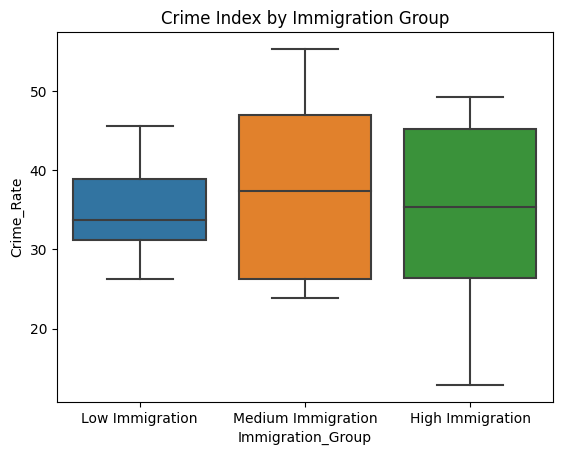

In [43]:
sns.boxplot(x='Immigration_Group', y='Crime_Rate', data=european_df)
plt.title("Crime Index by Immigration Group")
plt.show()

In [44]:
from scipy.stats import f_oneway

low = european_df[european_df['Immigration_Group'] == 'Low Immigration']['Crime_Rate']
medium = european_df[european_df['Immigration_Group'] == 'Medium Immigration']['Crime_Rate']
high = european_df[european_df['Immigration_Group'] == 'High Immigration']['Crime_Rate']

f_stat, p_value = f_oneway(low, medium, high)

print(f"F-statistic: {f_stat}")
print(f"P-value: {p_value}")


F-statistic: 0.1694557882168883
P-value: 0.8447584195076667


In [45]:
european_df.describe()

,Immigration_percentage,Crime_Rate
count,41.000000,41.000000
mean,17.297561,35.736585
std,14.444298,9.503361
min,1.700000,12.900000
25%,9.200000,26.800000
50%,14.200000,34.400000
75%,19.800000,45.100000
max,70.200000,55.300000


# Part 2: Detailed Analysis  
To strengthen my analysis, I decided to expand the dataset by including specific crime types instead of relying solely on a general crime index. Aggregated measures may hide important patterns, as different crimes—like homicide, burglary, or fraud—can be influenced by distinct factors. This enhancement allows for more targeted analysis and meaningful hypothesis testing to explore whether immigration correlates with particular crime categories.

To enrich the analysis, I included the Migrant Integration Policy Index (MIPEX) as it provides valuable insight into how well countries support the integration of immigrants through policies in areas like education, labor market mobility, and anti-discrimination. This index helps contextualize crime and immigration data by highlighting whether inclusive policies may influence societal outcomes. Since the most recent MIPEX data is from 2019, I aligned all other features—such as crime rates and immigration percentages—to that year to maintain consistency. Using 2019 data also avoids potential distortions caused by the COVID-19 pandemic, which significantly disrupted migration patterns and crime statistics.

Import Data

In [46]:
immigration_2019_df=pd.read_excel('immigration_data_2019.xlsx')
mipex_df=pd.read_excel('MIPEX.xlsx')
crime_2019_df=pd.read_excel('crime_2019.xlsx')

In [47]:
crime_2019_df.dtypes

GEO (Labels)      object
Homicide          object
SexualViolence    object
Rape              object
SexualAssault     object
Theft             object
dtype: object

In [48]:
# # Convert a specific column to numeric
# df['column_name'] = pd.to_numeric(df['Homicide'], errors='coerce')

In [49]:
crime_2019_df.isnull().sum()

GEO (Labels)      0
Homicide          0
SexualViolence    0
Rape              0
SexualAssault     0
Theft             0
dtype: int64

In [50]:
print(crime_2019_df.columns)
print(immigration_2019_df.columns)
print(mipex_df.columns)

Index(['GEO (Labels)', 'Homicide', 'SexualViolence', 'Rape', 'SexualAssault',
       'Theft'],
      dtype='object')
Index(['Country', 'Immigration', 'Population (thousands)'], dtype='object')
Index(['Country', 'MIPEX'], dtype='object')


In [51]:
crime_2019_df=standardize_country_names(crime_2019_df,'GEO (Labels)')
immigration_2019_df=standardize_country_names(immigration_2019_df,'Country')
mipex_df=standardize_country_names(mipex_df,'Country')

Scotland not found in regex
Northern Ireland not found in regex


In [52]:
print(crime_2019_df.columns,'size', crime_2019_df.shape)
print(immigration_2019_df.columns,'size', immigration_2019_df.size)
print(mipex_df.columns,'size',mipex_df.size)

Index(['GEO (Labels)', 'Homicide', 'SexualViolence', 'Rape', 'SexualAssault',
       'Theft', 'Country_standardized'],
      dtype='object') size (41, 7)
Index(['Country', 'Immigration', 'Population (thousands)',
       'Country_standardized'],
      dtype='object') size 188
Index(['Country', 'MIPEX', 'Country_standardized'], dtype='object') size 144


In [53]:
immigration_2019_df.head()

,Country,Immigration,Population (thousands),Country_standardized
1,Belarus,11.3,4400,Belarus
2,Bulgaria,2.4,3400,Bulgaria
3,Czechia,4.8,5261,Czechia
4,Hungary,5.3,4608,Hungary
5,Poland,1.7,18361,Poland


In [54]:
crime_2019_europe=filter_by_iso2(crime_2019_df,'Country_standardized')
immigration_2019_europe=filter_by_iso2(immigration_2019_df,'Country_standardized')
mipex_europe=filter_by_iso2(mipex_df,'Country_standardized')

Scotland not found in regex
Northern Ireland not found in regex


In [55]:
print(crime_2019_europe.columns,'shape', crime_2019_europe.shape)
print(immigration_2019_europe.columns,'shape',immigration_2019_europe.shape)
print(mipex_europe.columns,'shape',mipex_europe.shape)

Index(['GEO (Labels)', 'Homicide', 'SexualViolence', 'Rape', 'SexualAssault',
       'Theft', 'Country_standardized', 'flagCode'],
      dtype='object') shape (38, 8)
Index(['Country', 'Immigration', 'Population (thousands)',
       'Country_standardized', 'flagCode'],
      dtype='object') shape (44, 5)
Index(['Country', 'MIPEX', 'Country_standardized', 'flagCode'], dtype='object') shape (36, 4)


As seen above, crime data has 38 rows whereas immigration data has 44 and MIPEX data has 36. We will use inner join to find their overlap.

In [56]:
# Perform the inner join on the 'Country_standardized' column
merged_europe_df = pd.merge(crime_2019_europe, immigration_2019_europe, on='Country_standardized', how='inner')
merged_europe_df = pd.merge(merged_europe_df, mipex_europe, on='Country_standardized', how='inner')

# Print the shape and columns of the merged dataset
print(merged_europe_df.columns, 'shape', merged_europe_df.shape)


Index(['GEO (Labels)', 'Homicide', 'SexualViolence', 'Rape', 'SexualAssault',
       'Theft', 'Country_standardized', 'flagCode_x', 'Country_x',
       'Immigration', 'Population (thousands)', 'flagCode_y', 'Country_y',
       'MIPEX', 'flagCode'],
      dtype='object') shape (32, 15)


In [57]:
merged_europe_df.head()

,GEO (Labels),Homicide,SexualViolence,Rape,SexualAssault,Theft,Country_standardized,flagCode_x,Country_x,Immigration,Population (thousands),flagCode_y,Country_y,MIPEX,flagCode
0,Belgium,1.28,84.13,36.85,47.29,1985.09,Belgium,BE,Belgium,17.2,5711,BE,Belgium,69,BE
1,Bulgaria,1.16,8.64,1.87,6.77,473.88,Bulgaria,BG,Bulgaria,2.4,3400,BG,Bulgaria,40,BG
2,Czechia,0.76,14.65,6.41,8.12,561.98,Czechia,CZ,Czechia,4.8,5261,CZ,Czechia,50,CZ
3,Denmark,0.93,84.31,35.33,48.98,2928.71,Denmark,DK,Denmark,12.5,2870,DK,Denmark,49,DK
4,Germany,0.71,49.05,11.53,37.52,1235.04,Germany,DE,Germany,15.7,41249,DE,Germany,58,DE


In [58]:
#We can drop unnecessary columns
merged_europe_df.drop(columns=['GEO (Labels)', 'flagCode_x', 'Country_x','flagCode_y','Country_y','flagCode'], inplace=True)
merged_europe_df.head()

,Homicide,SexualViolence,Rape,SexualAssault,Theft,Country_standardized,Immigration,Population (thousands),MIPEX
0,1.28,84.13,36.85,47.29,1985.09,Belgium,17.2,5711,69
1,1.16,8.64,1.87,6.77,473.88,Bulgaria,2.4,3400,40
2,0.76,14.65,6.41,8.12,561.98,Czechia,4.8,5261,50
3,0.93,84.31,35.33,48.98,2928.71,Denmark,12.5,2870,49
4,0.71,49.05,11.53,37.52,1235.04,Germany,15.7,41249,58


In [59]:
#rearrange columns

# Step 1: Rename the column (assuming 'old_column_name' is the column you want to rename)
merged_europe_df.rename(columns={'Country_standardized': 'Country'}, inplace=True)

# Step 2: Rearrange columns to make 'new_column_name' the first column
cols = ['Country'] + [col for col in merged_europe_df if col != 'Country']
merged_europe_df = merged_europe_df[cols]

# Display the updated DataFrame
merged_europe_df.head()


,Country,Homicide,SexualViolence,Rape,SexualAssault,Theft,Immigration,Population (thousands),MIPEX
0,Belgium,1.28,84.13,36.85,47.29,1985.09,17.2,5711,69
1,Bulgaria,1.16,8.64,1.87,6.77,473.88,2.4,3400,40
2,Czechia,0.76,14.65,6.41,8.12,561.98,4.8,5261,50
3,Denmark,0.93,84.31,35.33,48.98,2928.71,12.5,2870,49
4,Germany,0.71,49.05,11.53,37.52,1235.04,15.7,41249,58


In [60]:
# Convert all columns that can be converted to numeric, leaving non-convertible values unchanged
merged_europe_df = merged_europe_df.apply(pd.to_numeric, errors='ignore')

# Display the updated DataFrame
print(merged_europe_df.head())


    Country  Homicide  SexualViolence   Rape SexualAssault    Theft  \
0   Belgium      1.28           84.13  36.85         47.29  1985.09   
1  Bulgaria      1.16            8.64   1.87          6.77   473.88   
2   Czechia      0.76           14.65   6.41          8.12   561.98   
3   Denmark      0.93           84.31  35.33         48.98  2928.71   
4   Germany      0.71           49.05  11.53         37.52  1235.04   

   Immigration  Population (thousands)  MIPEX  
0         17.2                    5711     69  
1          2.4                    3400     40  
2          4.8                    5261     50  
3         12.5                    2870     49  
4         15.7                   41249     58  


In [61]:
merged_europe_df.dtypes

Country                    object
Homicide                  float64
SexualViolence            float64
Rape                       object
SexualAssault              object
Theft                      object
Immigration               float64
Population (thousands)      int64
MIPEX                       int64
dtype: object

In [62]:
merged_europe_df['Rape'].isnull().sum()

0

In [63]:
merged_europe_df['Rape']

0     36.85
1      1.87
2      6.41
3     35.33
4     11.53
5     15.32
6     21.72
7       1.7
8      3.99
9     34.05
10    11.58
11        :
12     8.91
13     3.36
14     18.9
15      3.9
16     6.28
17    11.89
18    18.92
19     1.87
20     4.19
21     8.04
22     8.75
23     1.78
24    27.38
25    80.85
26    60.23
27    41.23
28     7.95
29     1.69
30     2.69
31     1.67
Name: Rape, dtype: object

The problem here is that missing values are shown as ":". So I need to handle some missing values. I will use the mean to handle them. 

In [64]:
# Replace ":" with NaN
merged_europe_df.replace(":", np.nan, inplace=True)

# Impute missing values with the mean of each column
df = merged_europe_df.apply(lambda col: col.fillna(col.mean()) if col.dtype in ['float64', 'int64'] else col)

# Check the updated DataFrame
print(df.head())

    Country  Homicide  SexualViolence   Rape  SexualAssault    Theft  \
0   Belgium      1.28           84.13  36.85          47.29  1985.09   
1  Bulgaria      1.16            8.64   1.87           6.77   473.88   
2   Czechia      0.76           14.65   6.41           8.12   561.98   
3   Denmark      0.93           84.31  35.33          48.98  2928.71   
4   Germany      0.71           49.05  11.53          37.52  1235.04   

   Immigration  Population (thousands)  MIPEX  
0         17.2                    5711     69  
1          2.4                    3400     40  
2          4.8                    5261     50  
3         12.5                    2870     49  
4         15.7                   41249     58  


In [65]:
# Ensure ":" is treated as string and replaced
merged_europe_df.replace(":", np.nan, inplace=True)
# Convert all relevant columns to numeric, coercing errors into NaN
for col in merged_europe_df.columns:
    if col not in ['Country']:  # skip non-numeric columns like 'Country'
        merged_europe_df[col] = pd.to_numeric(merged_europe_df[col], errors='coerce')
print(merged_europe_df.isna().sum())
# Fill NaNs with column mean for numeric columns
merged_europe_df = merged_europe_df.fillna(merged_europe_df.mean(numeric_only=True))


Country                   0
Homicide                  0
SexualViolence            0
Rape                      1
SexualAssault             4
Theft                     1
Immigration               0
Population (thousands)    0
MIPEX                     0
dtype: int64


In [66]:
df.isnull().sum()

Country                   0
Homicide                  0
SexualViolence            0
Rape                      0
SexualAssault             0
Theft                     0
Immigration               0
Population (thousands)    0
MIPEX                     0
dtype: int64

In [67]:
merged_europe_df['SexualAssault']

0      47.290000
1       6.770000
2       8.120000
3      48.980000
4      37.520000
5      11.470000
6      36.560000
7       0.650000
8      23.770000
9      48.160000
10      8.610000
11     21.884643
12      7.080000
13      3.440000
14     21.884643
15     21.884643
16     17.830000
17     12.990000
18     26.640000
19      1.520000
20     22.090000
21      1.810000
22      2.840000
23      1.430000
24     45.270000
25    108.910000
26     19.890000
27     46.750000
28      7.330000
29     21.884643
30      2.690000
31      6.360000
Name: SexualAssault, dtype: float64

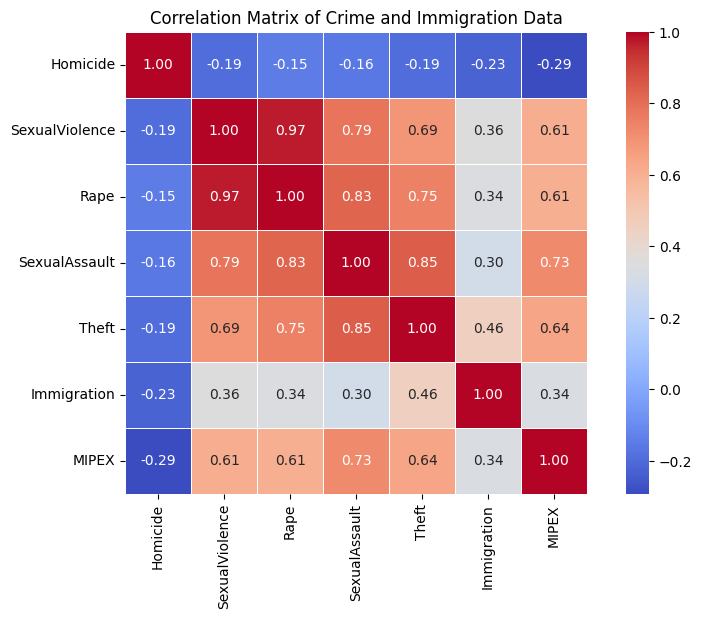

In [68]:
numerical_data = merged_europe_df[['Homicide', 'SexualViolence', 'Rape', 'SexualAssault', 'Theft', 'Immigration', 'MIPEX']]

# Compute the correlation matrix
correlation_matrix = numerical_data.corr()

# Create a heatmap of the correlation matrix
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5,square=True)
plt.title('Correlation Matrix of Crime and Immigration Data')
plt.show()

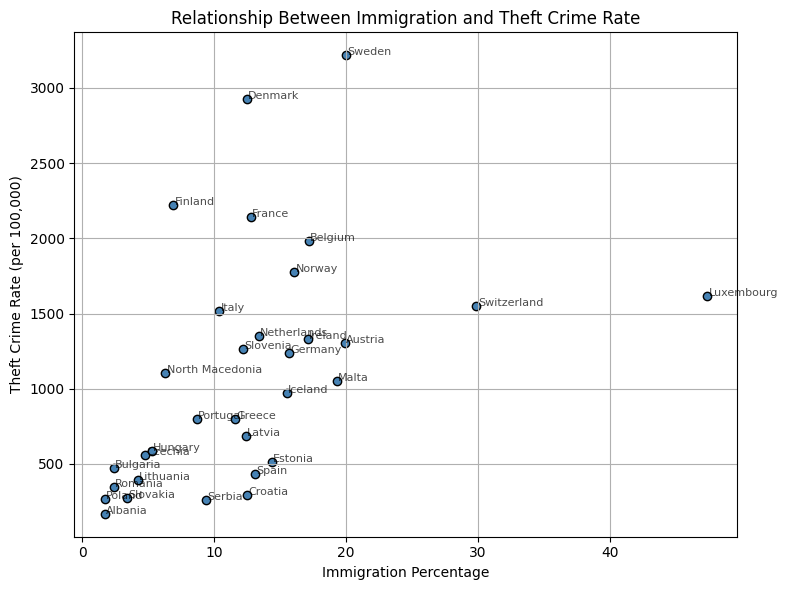

In [69]:
# Scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(merged_europe_df['Immigration'], merged_europe_df['Theft'], color='steelblue', edgecolor='black')

# Add labels and title
plt.xlabel('Immigration Percentage')
plt.ylabel('Theft Crime Rate (per 100,000)')
plt.title('Relationship Between Immigration and Theft Crime Rate')

# Optional: Add country labels
for i, row in merged_europe_df.iterrows():
    plt.text(row['Immigration'] + 0.1, row['Theft'] + 0.1, row['Country'], fontsize=8, alpha=0.7)

plt.grid(True)
plt.tight_layout()
plt.show()

In [70]:
# Calculate the median immigration value
median_immigration = merged_europe_df['Immigration'].median()

# Create a new column categorizing immigration as 'Low' or 'High'
merged_europe_df['Immigration_Level'] = merged_europe_df['Immigration'].apply(
    lambda x: 'Low' if x < median_immigration else 'High'
)

# Check the result
print(merged_europe_df[['Country', 'Immigration', 'Immigration_Level']].head(40))

            Country  Immigration Immigration_Level
0           Belgium         17.2              High
1          Bulgaria          2.4               Low
2           Czechia          4.8               Low
3           Denmark         12.5              High
4           Germany         15.7              High
5           Estonia         14.4              High
6           Ireland         17.1              High
7            Greece         11.6               Low
8             Spain         13.1              High
9            France         12.8              High
10          Croatia         12.5              High
11            Italy         10.4               Low
12           Latvia         12.4               Low
13        Lithuania          4.2               Low
14       Luxembourg         47.4              High
15          Hungary          5.3               Low
16            Malta         19.3              High
17      Netherlands         13.4              High
18          Austria         19.

In [71]:
merged_europe_df.isnull().sum()

Country                   0
Homicide                  0
SexualViolence            0
Rape                      0
SexualAssault             0
Theft                     0
Immigration               0
Population (thousands)    0
MIPEX                     0
Immigration_Level         0
dtype: int64

In [72]:
from scipy.stats import ttest_ind

# Divide the groups
low_immigration = merged_europe_df[merged_europe_df['Immigration_Level'] == 'Low']['Theft']
high_immigration = merged_europe_df[merged_europe_df['Immigration_Level'] == 'High']['Theft']

# Perform the t-test
t_stat, p_value = ttest_ind(low_immigration, high_immigration)

print("T-statistic:", t_stat)
print("P-value:", p_value)

# Interpret the result
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis: There is a significant difference in theft rates between low and high immigration countries.")
else:
    print("Fail to reject the null hypothesis: No significant difference in theft rates between the two groups.")


T-statistic: -3.044028159951456
P-value: 0.004823368470729481
Reject the null hypothesis: There is a significant difference in theft rates between low and high immigration countries.


# Part 3: Machine Learning Models

### Data Enrichment

Due to the feedback I got on about the data enrichment, I added several new features such as refugee and asylum seeker percentages in addition to immigration percentage and other econmic features such as GDP per capita, annual inflation and Gini index. 

In [73]:
#This is the initial dataframe
merged_europe_df.head()

,Country,Homicide,SexualViolence,Rape,SexualAssault,Theft,Immigration,Population (thousands),MIPEX,Immigration_Level
0,Belgium,1.28,84.13,36.85,47.29,1985.09,17.2,5711,69,High
1,Bulgaria,1.16,8.64,1.87,6.77,473.88,2.4,3400,40,Low
2,Czechia,0.76,14.65,6.41,8.12,561.98,4.8,5261,50,Low
3,Denmark,0.93,84.31,35.33,48.98,2928.71,12.5,2870,49,High
4,Germany,0.71,49.05,11.53,37.52,1235.04,15.7,41249,58,High


In [74]:
#import new data
world_bank_df=pd.read_excel('world_bank.xlsx')

In [75]:
world_bank_df.head()

,Sum of 2019 [YR2019],Column Labels,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12
0,Row Labels,Asylum-seekers by country or territory of asylum,Data from database: World Development Indicators,GDP per capita (current US$),Gini index,"Inflation, consumer prices (annual %)",International migrant stock (% of population),Last Updated: 04/15/2025,"Population, total",Refugees under the mandate of the UNHCR by cou...,"Unemployment, total (% of total labor force) (...",(blank),Grand Total
1,Afghanistan,247,NaN,496.602504,0,2.302373,0,NaN,37856121,72227,0,NaN,37929093.904877
2,Africa Eastern and Southern,442915,NaN,1493.780445,0,4.644967,0,NaN,675950189,5087755,0,NaN,681482357.425412
3,Africa Western and Central,76732,NaN,1783.654365,0,1.983092,0,NaN,463365429,1315229,7.783835,NaN,464759183.421292
4,Albania,5,NaN,5460.428237,30.1,1.411091,0,NaN,2854191,120,11.466,NaN,2859819.405328


This dataframe requires some cleaning and organization.

In [76]:
#organize data frame
#replace column names with the values from first row
world_bank_df.columns=world_bank_df.iloc[0]
#drop first row
world_bank_df = world_bank_df[1:] 

In [77]:
#drop unnecessary columns
world_bank_df=world_bank_df.drop(columns=["(blank)","Grand Total","Data from database: World Development Indicators","Last Updated: 04/15/2025","International migrant stock (% of population)"])

In [78]:
world_bank_df.head()

,Row Labels,Asylum-seekers by country or territory of asylum,GDP per capita (current US$),Gini index,"Inflation, consumer prices (annual %)","Population, total",Refugees under the mandate of the UNHCR by country or territory of asylum,"Unemployment, total (% of total labor force) (national estimate)"
1,Afghanistan,247,496.602504,0,2.302373,37856121,72227,0
2,Africa Eastern and Southern,442915,1493.780445,0,4.644967,675950189,5087755,0
3,Africa Western and Central,76732,1783.654365,0,1.983092,463365429,1315229,7.783835
4,Albania,5,5460.428237,30.1,1.411091,2854191,120,11.466
5,Algeria,1647,4468.453419,0,1.951768,43294546,98599,0


In [79]:
#check null values
world_bank_df.isnull().sum()

0
Row Labels                                                                   0
Asylum-seekers by country or territory of asylum                             1
GDP per capita (current US$)                                                 1
Gini index                                                                   1
Inflation, consumer prices (annual %)                                        1
Population, total                                                            1
Refugees under the mandate of the UNHCR by country or territory of asylum    1
Unemployment, total (% of total labor force) (national estimate)             1
dtype: int64

Asylum seekers and refugees are given as raw counts. To make them comparable across countries with different population sizes, I divide them by total population and multiply by 100. We have to drop rows with missing values to do proper division.

In [80]:
world_bank_df = world_bank_df[world_bank_df["Population, total"] != 0]


In [81]:
world_bank_df["Asylum Seeker(%)"]=(world_bank_df["Asylum-seekers by country or territory of asylum"]/world_bank_df["Population, total"])*100
world_bank_df["Refugee(%)"]=(world_bank_df["Refugees under the mandate of the UNHCR by country or territory of asylum"]/world_bank_df["Population, total"])*100


In [82]:
world_bank_df.head()

,Row Labels,Asylum-seekers by country or territory of asylum,GDP per capita (current US$),Gini index,"Inflation, consumer prices (annual %)","Population, total",Refugees under the mandate of the UNHCR by country or territory of asylum,"Unemployment, total (% of total labor force) (national estimate)",Asylum Seeker(%),Refugee(%)
1,Afghanistan,247,496.602504,0,2.302373,37856121,72227,0,0.000652,0.190793
2,Africa Eastern and Southern,442915,1493.780445,0,4.644967,675950189,5087755,0,0.065525,0.752682
3,Africa Western and Central,76732,1783.654365,0,1.983092,463365429,1315229,7.783835,0.01656,0.283843
4,Albania,5,5460.428237,30.1,1.411091,2854191,120,11.466,0.000175,0.004204
5,Algeria,1647,4468.453419,0,1.951768,43294546,98599,0,0.003804,0.22774


In [83]:
#drop raw count columns
world_bank_df=world_bank_df.drop(columns=["Asylum-seekers by country or territory of asylum","Refugees under the mandate of the UNHCR by country or territory of asylum"])
world_bank_df.rename(columns={'Unemployment, total (% of total labor force) (national estimate)': 'Unemployment','Inflation, consumer prices (annual %)':'Inflation','GDP per capita (current US$)':'GDP'}, inplace=True)


In [84]:
world_bank_df['Row Labels'].dtype


dtype('O')

In [85]:
world_bank_df['Row Labels'] = world_bank_df['Row Labels'].astype(str)


In [86]:
world_bank_df['Row Labels'].dtype


dtype('O')

In [87]:
world_bank_df = standardize_country_names(world_bank_df, country_col='Row Labels')


Africa Eastern and Southern not found in regex
Africa Western and Central not found in regex
Arab World not found in regex
Caribbean small states not found in regex
Central Europe and the Baltics not found in regex
Early-demographic dividend not found in regex
East Asia & Pacific not found in regex
East Asia & Pacific not found in regex
East Asia & Pacific not found in regex
Euro area not found in regex
Europe & Central Asia not found in regex
Europe & Central Asia not found in regex
Europe & Central Asia not found in regex
European Union not found in regex
Fragile and conflict affected situations not found in regex
Heavily indebted poor countries not found in regex
High income not found in regex
IBRD only not found in regex
IDA & IBRD total not found in regex
IDA blend not found in regex
IDA only not found in regex
IDA total not found in regex
Late-demographic dividend not found in regex
Latin America & Caribbean not found in regex
Latin America & Caribbean not found in regex
Latin Am

In [88]:
world_bank_df.head()

,Row Labels,GDP,Gini index,Inflation,"Population, total",Unemployment,Asylum Seeker(%),Refugee(%),Country_standardized
1,Afghanistan,496.602504,0,2.302373,37856121,0,0.000652,0.190793,Afghanistan
2,Africa Eastern and Southern,1493.780445,0,4.644967,675950189,0,0.065525,0.752682,Africa Eastern and Southern
3,Africa Western and Central,1783.654365,0,1.983092,463365429,7.783835,0.01656,0.283843,Africa Western and Central
4,Albania,5460.428237,30.1,1.411091,2854191,11.466,0.000175,0.004204,Albania
5,Algeria,4468.453419,0,1.951768,43294546,0,0.003804,0.22774,Algeria


Now we can merge new data with initial data which is "merged_europe_df". We can drop population and immigration level columns as we already have them in new data. 

In [89]:
merged_europe_df.head()

,Country,Homicide,SexualViolence,Rape,SexualAssault,Theft,Immigration,Population (thousands),MIPEX,Immigration_Level
0,Belgium,1.28,84.13,36.85,47.29,1985.09,17.2,5711,69,High
1,Bulgaria,1.16,8.64,1.87,6.77,473.88,2.4,3400,40,Low
2,Czechia,0.76,14.65,6.41,8.12,561.98,4.8,5261,50,Low
3,Denmark,0.93,84.31,35.33,48.98,2928.71,12.5,2870,49,High
4,Germany,0.71,49.05,11.53,37.52,1235.04,15.7,41249,58,High


In [90]:
old_data_df=merged_europe_df.drop(columns=["Population (thousands)","Immigration_Level"])

In [91]:
old_data_df.rename(columns={'Country_standardized': 'Country'}, inplace=True)


Inner join to get common rows (European countries).

In [92]:
new_df = pd.merge(
    world_bank_df,
    old_data_df,
    left_on='Country_standardized',
    right_on='Country',
    how='inner'
)


In [93]:
new_df.head()

,Row Labels,GDP,Gini index,Inflation,"Population, total",Unemployment,Asylum Seeker(%),Refugee(%),Country_standardized,Country,Homicide,SexualViolence,Rape,SexualAssault,Theft,Immigration,MIPEX
0,Albania,5460.428237,30.1,1.411091,2854191,11.466,0.000175,0.004204,Albania,Albania,2.03,5.38,2.69,2.69,168.84,1.7,43
1,Austria,49885.994736,30.2,1.530896,8879920,4.56,0.300633,1.530994,Austria,Austria,0.84,50.90,18.92,26.64,1302.92,19.9,46
2,Belgium,46716.622747,27.2,1.43682,11488980,5.364,0.094543,0.536706,Belgium,Belgium,1.28,84.13,36.85,47.29,1985.09,17.2,69
3,Bulgaria,9838.60059,40.3,3.103729,6975761,4.23,0.015109,0.292986,Bulgaria,Bulgaria,1.16,8.64,1.87,6.77,473.88,2.4,40
4,Croatia,15563.81674,28.9,0.77182,3949390,6.617,0.011495,0.023193,Croatia,Croatia,0.81,21.05,11.58,8.61,291.00,12.5,39


In [94]:
new_df.shape

(32, 17)

In [95]:
#drop unnecessary columns
new_df=new_df.drop(columns=["Country_standardized","Row Labels","Population, total"])

In [96]:
#check null values
new_df.isnull().sum()

GDP                 0
Gini index          0
Inflation           0
Unemployment        0
Asylum Seeker(%)    0
Refugee(%)          0
Country             0
Homicide            0
SexualViolence      0
Rape                0
SexualAssault       0
Theft               0
Immigration         0
MIPEX               0
dtype: int64

In [97]:
new_df.head()

,GDP,Gini index,Inflation,Unemployment,Asylum Seeker(%),Refugee(%),Country,Homicide,SexualViolence,Rape,SexualAssault,Theft,Immigration,MIPEX
0,5460.428237,30.1,1.411091,11.466,0.000175,0.004204,Albania,2.03,5.38,2.69,2.69,168.84,1.7,43
1,49885.994736,30.2,1.530896,4.56,0.300633,1.530994,Austria,0.84,50.90,18.92,26.64,1302.92,19.9,46
2,46716.622747,27.2,1.43682,5.364,0.094543,0.536706,Belgium,1.28,84.13,36.85,47.29,1985.09,17.2,69
3,9838.60059,40.3,3.103729,4.23,0.015109,0.292986,Bulgaria,1.16,8.64,1.87,6.77,473.88,2.4,40
4,15563.81674,28.9,0.77182,6.617,0.011495,0.023193,Croatia,0.81,21.05,11.58,8.61,291.00,12.5,39


### Machine Learning Models

First prepare the dataset for machine learning models. 

In [98]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [99]:
df_model=new_df.drop(columns=["Country"])

In [100]:
# Convert all object columns that should be numeric
for col in df_model.columns:
    if df_model[col].dtype == 'O':  # object type
        df_model[col] = pd.to_numeric(df_model[col], errors='coerce')


Check for multicollinearity.

### Correlation Matrix

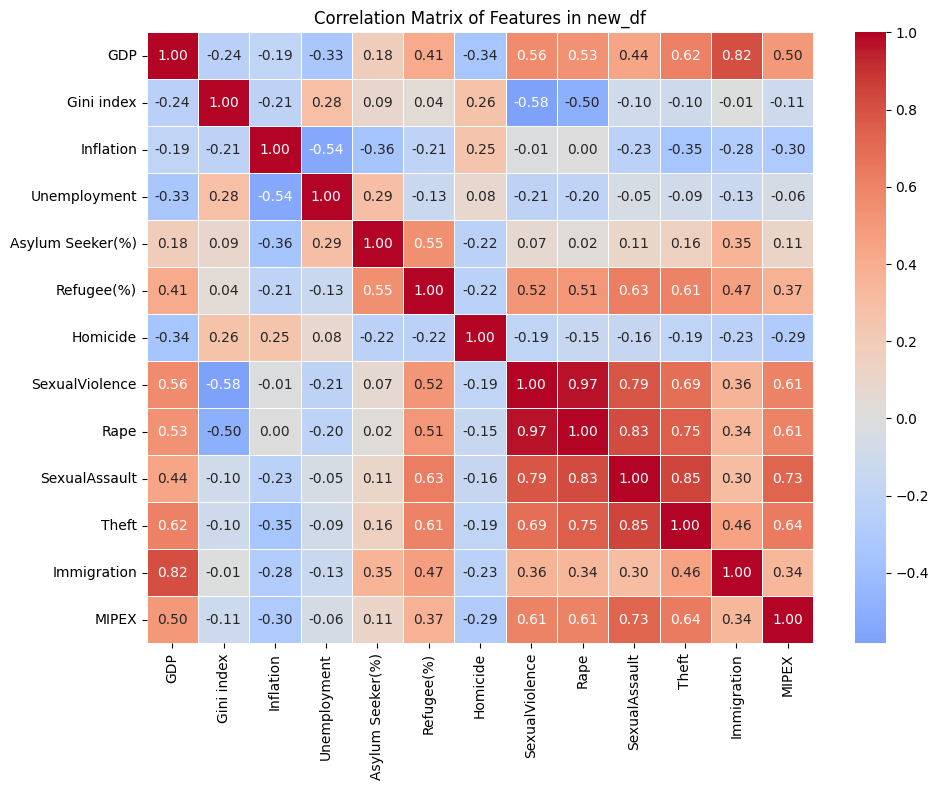

In [133]:
# Compute the correlation matrix
corr_matrix = df_model.corr(numeric_only=True)  # ensures only numeric columns are included

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', center=0, linewidths=0.5)
plt.title("Correlation Matrix of Features in new_df")
plt.tight_layout()
plt.savefig('data_enrichment.png')
plt.show()


In [102]:
x = df_model.drop(columns=['Theft'])
y = df_model['Theft']

Varience Inflation Factor (VIF)

In [103]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

# Ensure all features are numeric (and drop non-numeric if any)
X = x.select_dtypes(include=[float, int]).copy()

# Add a constant column for intercept
X_const = sm.add_constant(X)

# Compute VIF for each feature
vif_df = pd.DataFrame()
vif_df["Feature"] = X_const.columns
vif_df["VIF"] = [variance_inflation_factor(X_const.values, i) for i in range(X_const.shape[1])]

print(vif_df)


             Feature         VIF
0              const  129.497169
1                GDP    5.985206
2         Gini index    4.924983
3          Inflation    2.422848
4       Unemployment    2.885739
5   Asylum Seeker(%)    2.574919
6         Refugee(%)    4.642314
7           Homicide    1.531897
8     SexualViolence   28.828478
9               Rape   23.535730
10     SexualAssault    9.436319
11       Immigration    4.522729
12             MIPEX    2.855417


In [104]:
x.head()

,GDP,Gini index,Inflation,Unemployment,Asylum Seeker(%),Refugee(%),Homicide,SexualViolence,Rape,SexualAssault,Immigration,MIPEX
0,5460.428237,30.1,1.411091,11.466,0.000175,0.004204,2.03,5.38,2.69,2.69,1.7,43
1,49885.994736,30.2,1.530896,4.560,0.300633,1.530994,0.84,50.90,18.92,26.64,19.9,46
2,46716.622747,27.2,1.436820,5.364,0.094543,0.536706,1.28,84.13,36.85,47.29,17.2,69
3,9838.600590,40.3,3.103729,4.230,0.015109,0.292986,1.16,8.64,1.87,6.77,2.4,40
4,15563.816740,28.9,0.771820,6.617,0.011495,0.023193,0.81,21.05,11.58,8.61,12.5,39


Sexual violence and rape show very high multicollinearity.  Sexual assault also has a high VIF, which may indicate additional overlap with rape and sexual violence, which doesn't come at surprise. To reduce multicollinearity and improve the models, we can remove or combine correlated features. I employed Principal Component (PCA) to capture most of the varience. 

In [105]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Select and scale only the 3 columns
crime_features = x[["Rape", "SexualViolence", "SexualAssault"]]
crime_scaled = StandardScaler().fit_transform(crime_features)

# Apply PCA
pca = PCA(n_components=1)
x["Sexual_Crime_PC1"] = pca.fit_transform(crime_scaled)


In [106]:
x.head()

,GDP,Gini index,Inflation,Unemployment,Asylum Seeker(%),Refugee(%),Homicide,SexualViolence,Rape,SexualAssault,Immigration,MIPEX,Sexual_Crime_PC1
0,5460.428237,30.1,1.411091,11.466,0.000175,0.004204,2.03,5.38,2.69,2.69,1.7,43,-1.364330
1,49885.994736,30.2,1.530896,4.560,0.300633,1.530994,0.84,50.90,18.92,26.64,19.9,46,0.333701
2,46716.622747,27.2,1.436820,5.364,0.094543,0.536706,1.28,84.13,36.85,47.29,17.2,69,1.851344
3,9838.600590,40.3,3.103729,4.230,0.015109,0.292986,1.16,8.64,1.87,6.77,2.4,40,-1.248300
4,15563.816740,28.9,0.771820,6.617,0.011495,0.023193,0.81,21.05,11.58,8.61,12.5,39,-0.730048


I created 2 datasets: one with PCA performed and one with no PCA performed. This way I can oberve the effect of multicollinearity and PCA. 

In [107]:
#drop the originals
x_pca = x.drop(columns=["Rape", "SexualViolence", "SexualAssault"])
x_no_pca=x.drop(columns="Sexual_Crime_PC1")

In [108]:
x_train, x_test, y_train, y_test = train_test_split(x_no_pca, y, test_size=0.2, random_state=42)
x_pca_train, x_pca_test, y_pca_train, y_pca_test = train_test_split(x_pca, y, test_size=0.2, random_state=42)


### Linear Regression

Linear regression is not counted as valid ML method for the course but I use it for baseline error. 

In [109]:
from sklearn.linear_model import LinearRegression

# Initialize and fit the model
linreg = LinearRegression()
linreg.fit(x_pca_train, y_pca_train)

# Predict on test set
y_pred_lin = linreg.predict(x_pca_test)

# Evaluate the model
mse = mean_squared_error(y_pca_test, y_pred_lin)
rmse = np.sqrt(mse)
r2 = r2_score(y_pca_test, y_pred_lin)

print("Linear Regression Results:")
print(f"  MSE: {mse:.2f}")
print(f"  RMSE: {rmse:.2f}")
print(f"  R² : {r2:.2f}")


Linear Regression Results:
  MSE: 141594.94
  RMSE: 376.29
  R² : 0.85


We can see the coefficients to understand which features are positively or negatively associated with theft in the model.

            Feature  Coefficient
9  Sexual_Crime_PC1   332.035129
2         Inflation  -208.071879
4  Asylum Seeker(%)  -139.290154
5        Refugee(%)   115.806699
1        Gini index    28.535315
6          Homicide    10.476596
7       Immigration    -9.202153
3      Unemployment    -9.001840
8             MIPEX    -4.214279
0               GDP     0.008745


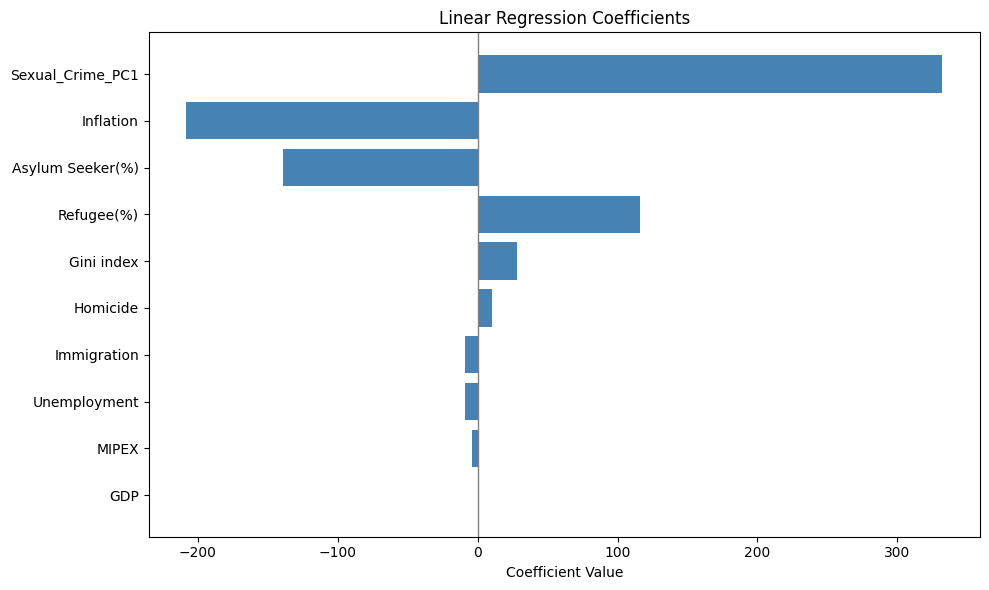

In [110]:
# Sort features by absolute coefficient magnitude
coefficients = pd.DataFrame({
    'Feature': x_pca_train.columns,
    'Coefficient': linreg.coef_
}).sort_values(by='Coefficient', key=abs, ascending=False)
print(coefficients)
# Plot
plt.figure(figsize=(10, 6))
plt.barh(coefficients['Feature'], coefficients['Coefficient'], color='steelblue')
plt.axvline(0, color='gray', linewidth=1)
plt.title('Linear Regression Coefficients')
plt.xlabel('Coefficient Value')
plt.gca().invert_yaxis()  # Highest at top
plt.tight_layout()
plt.savefig('linear-regression-coefficients.png')
plt.show()


Now I train and test the model with no PCA data.

In [111]:
from sklearn.linear_model import LinearRegression

# Initialize and fit the model
linreg = LinearRegression()
linreg.fit(x_train, y_train)

# Predict on test set
y_pred_lin = linreg.predict(x_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred_lin)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred_lin)

print("Linear Regression Results:")
print(f"  MSE: {mse:.2f}")
print(f"  RMSE: {rmse:.2f}")
print(f"  R² : {r2:.2f}")


Linear Regression Results:
  MSE: 239540.30
  RMSE: 489.43
  R² : 0.75


 R² dropped from 0.85 to 0.75 and RMSE increased from 376.29 to 489.43. This demonstartes the effect of PCA. 

### Decision Tree

In [112]:
#use non-PCA data
from sklearn.tree import DecisionTreeRegressor

# Train the model
dtree = DecisionTreeRegressor(random_state=42)
dtree.fit(x_train, y_train)

# Predict and evaluate
y_pred_tree = dtree.predict(x_test)

print("Decision Tree MSE:", mean_squared_error(y_test, y_pred_tree))
print("Decision Tree RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_tree)))
print("Decision Tree R²:", r2_score(y_test, y_pred_tree))

# Get actual depth of the fitted tree
print("Actual max depth of the tree:", dtree.get_depth())


Decision Tree MSE: 203006.77170069862
Decision Tree RMSE: 450.5627278201101
Decision Tree R²: 0.7889245043686326
Actual max depth of the tree: 9


In [113]:
#use PCA data
from sklearn.tree import DecisionTreeRegressor

# Train the model
dtree = DecisionTreeRegressor(random_state=42)
dtree.fit(x_pca_train, y_pca_train)

# Predict and evaluate
y_pred_tree = dtree.predict(x_pca_test)

print("Decision Tree MSE:", mean_squared_error(y_pca_test, y_pred_tree))
print("Decision Tree RMSE:", np.sqrt(mean_squared_error(y_pca_test, y_pred_tree)))
print("Decision Tree R²:", r2_score(y_pca_test, y_pred_tree))


Decision Tree MSE: 419152.1055857143
Decision Tree RMSE: 647.4195746080854
Decision Tree R²: 0.5641882401742


-->Observe that using PCA data decreases R² unlike linear regression.

Cross Validation for Decision Tree

k=2 → Average MSE: 688.27
k=3 → Average MSE: 680.69
k=4 → Average MSE: 682.03
k=5 → Average MSE: 650.93
k=6 → Average MSE: 641.75
k=7 → Average MSE: 664.87
k=8 → Average MSE: 663.42
k=9 → Average MSE: 726.13
k=10 → Average MSE: 733.31
k=11 → Average MSE: 715.38
k=12 → Average MSE: 660.17
k=13 → Average MSE: 675.64
k=14 → Average MSE: 672.62
k=15 → Average MSE: 646.52
k=16 → Average MSE: 639.13
k=17 → Average MSE: 693.19
k=18 → Average MSE: 682.90
k=19 → Average MSE: 665.25
k=20 → Average MSE: 649.23
k=21 → Average MSE: 684.71
k=22 → Average MSE: 703.38
k=23 → Average MSE: 695.57
k=24 → Average MSE: 682.77
k=25 → Average MSE: 687.34
k=26 → Average MSE: 675.96
k=27 → Average MSE: 670.39
k=28 → Average MSE: 677.26
k=29 → Average MSE: 691.35
k=30 → Average MSE: 681.43
k=31 → Average MSE: 677.27
k=32 → Average MSE: 693.78


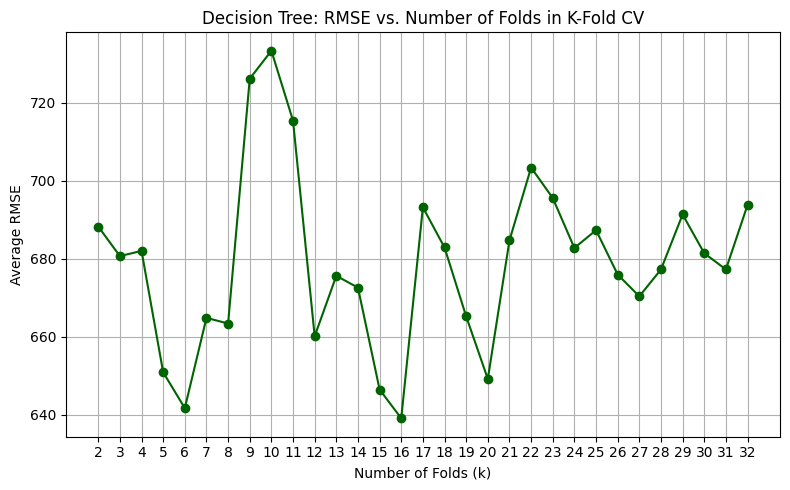

In [114]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

# Define range of k values (number of folds)
k_values = list(range(2, 33))  #leave-one-out is 32
rmse_results = []

for k in k_values:
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    fold_mse = []

    for train_idx, test_idx in kf.split(x_no_pca):
        x_train_cv, x_test_cv = x_no_pca.iloc[train_idx], x_no_pca.iloc[test_idx]
        y_train_cv, y_test_cv = y.iloc[train_idx], y.iloc[test_idx]

        dtree.fit(x_train_cv, y_train_cv)
        y_pred_cv = dtree.predict(x_test_cv)

        fold_mse.append(mean_squared_error(y_test_cv, y_pred_cv))

    avg_rmse =np.sqrt(np.mean(fold_mse))
    rmse_results.append(avg_rmse)
    print(f"k={k} → Average MSE: {avg_rmse:.2f}")

# Plotting
plt.figure(figsize=(8, 5))
plt.plot(k_values, rmse_results, marker='o', linestyle='-', color='darkgreen')
plt.title('Decision Tree: RMSE vs. Number of Folds in K-Fold CV')
plt.xlabel('Number of Folds (k)')
plt.ylabel('Average RMSE')
plt.xticks(k_values)
plt.grid(True)
plt.tight_layout()
plt.savefig('dtree_k_fold.png')
plt.show()


Hyperparameter tuning for Decision Tree
* criterion
* splitter
* max_depth
* min_samples_split
* min_samples_leaf
* max_features

In [115]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Initialize model
dtree = DecisionTreeRegressor(random_state=42)

param_grid = {
    'max_depth': [2, 3, 4, 5, None],
    'criterion': ['squared_error', 'friedman_mse'],
    'splitter': ['best', 'random'],
    'max_features': [None, 'sqrt', 'log2']
}


# Grid search
grid_search = GridSearchCV(
    dtree,
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

# Fit on training data
grid_search.fit(x_train, y_train)

# Use best model
best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(x_test)

# Evaluate
mse = mean_squared_error(y_test, y_pred_best)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred_best)

print("Best parameters:", grid_search.best_params_)
print("Tuned Decision Tree MSE:", mse)
print("Tuned Decision Tree RMSE:", rmse)
print("Tuned Decision Tree R²:", r2)


Best parameters: {'criterion': 'squared_error', 'max_depth': 4, 'max_features': None, 'splitter': 'random'}
Tuned Decision Tree MSE: 454549.28549841273
Tuned Decision Tree RMSE: 674.202703568009
Tuned Decision Tree R²: 0.5273841610223922


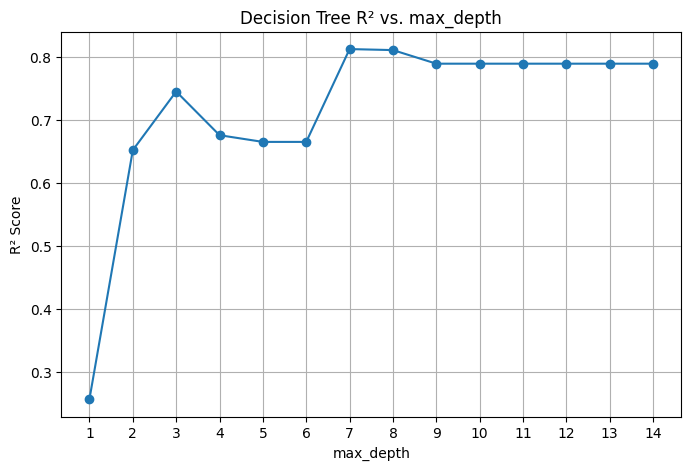

In [116]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split


# Test different tree depths
depths = range(1, 15)
r2_scores = []

for depth in depths:
    model = DecisionTreeRegressor(max_depth=depth, random_state=42)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    r2 = r2_score(y_test, y_pred)
    r2_scores.append(r2)

# Plot R² vs max_depth
plt.figure(figsize=(8, 5))
plt.plot(depths, r2_scores, marker='o', linestyle='-')
plt.xlabel("max_depth")
plt.ylabel("R² Score")
plt.title("Decision Tree R² vs. max_depth")
plt.grid(True)
plt.xticks(depths)
plt.savefig('dtree_max_depth.png')
plt.show()


### Random Forest

In [117]:
#use non-PCA data
from sklearn.ensemble import RandomForestRegressor

# Train the model
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(x_train, y_train)

# Predict and evaluate
y_pred_rf = rf.predict(x_test)

print("Random Forest MSE:", mean_squared_error(y_test, y_pred_rf))
print("Decision Tree RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_rf)))
print("Random Forest R²:", r2_score(y_test, y_pred_rf))

# Get actual depth of the fitted tree
# print("Actual max depth of the tree:", rf.get_depth())

# Get depth of each tree in the forest
tree_depths = [estimator.get_depth() for estimator in rf.estimators_]

# View the depths
print("Tree depths:", tree_depths)
print("Average depth:", np.mean(tree_depths))
print("Max depth among trees:", np.max(tree_depths))


Random Forest MSE: 257491.49473488802
Decision Tree RMSE: 507.4361976986743
Random Forest R²: 0.7322742270284519
Tree depths: [7, 6, 8, 7, 7, 6, 6, 7, 6, 6, 8, 6, 7, 6, 7, 9, 6, 6, 7, 8, 6, 7, 6, 8, 6, 5, 6, 6, 6, 6, 6, 7, 6, 6, 6, 6, 6, 7, 6, 6, 7, 7, 7, 5, 6, 8, 6, 6, 5, 6, 5, 6, 6, 6, 7, 6, 6, 7, 6, 6, 8, 5, 6, 7, 5, 8, 7, 6, 7, 6, 6, 7, 6, 6, 6, 7, 6, 8, 6, 6, 6, 7, 7, 6, 7, 8, 6, 7, 6, 6, 7, 6, 6, 7, 6, 6, 6, 7, 7, 7]
Average depth: 6.44
Max depth among trees: 9


In [118]:
#use PCA data
from sklearn.ensemble import RandomForestRegressor

# Train the model
rf_pca = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(x_pca_train, y_pca_train)

# Predict and evaluate
y_pred_rf = rf.predict(x_pca_test)

print("Random Forest MSE:", mean_squared_error(y_pca_test, y_pred_rf))
print("Decision Tree RMSE:", np.sqrt(mean_squared_error(y_pca_test, y_pred_rf)))
print("Random Forest R²:", r2_score(y_pca_test, y_pred_rf))


Random Forest MSE: 344133.921855135
Decision Tree RMSE: 586.6292882691206
Random Forest R²: 0.6421881028371188


In [119]:
from sklearn.model_selection import GridSearchCV
# Define parameter grid
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 10, None],
    'criterion': ['squared_error', 'friedman_mse'],
    'max_features': [None, 'sqrt', 'log2']
    #'min_samples_split': [2, 5],
    #'min_samples_leaf': [1, 2]
}

# Initialize model
rf_model = RandomForestRegressor(random_state=42)

# Grid search
grid_rf = GridSearchCV(rf_model, param_grid_rf, cv=5, scoring='r2', n_jobs=-1)
grid_rf.fit(x_train, y_train)

# Best model
best_rf = grid_rf.best_estimator_
y_pred_best_rf = best_rf.predict(x_test)

# Evaluate
print("Best Random Forest Parameters:", grid_rf.best_params_)
print("Tuned Random Forest R²:", r2_score(y_test, y_pred_best_rf))
print("Tuned Random Forest MSE:", mean_squared_error(y_test, y_pred_best_rf))


Best Random Forest Parameters: {'criterion': 'squared_error', 'max_depth': 5, 'max_features': None, 'n_estimators': 50}
Tuned Random Forest R²: 0.714018462232368
Tuned Random Forest MSE: 275049.40151651035


Observe the effect of number of estimators on the performance. 

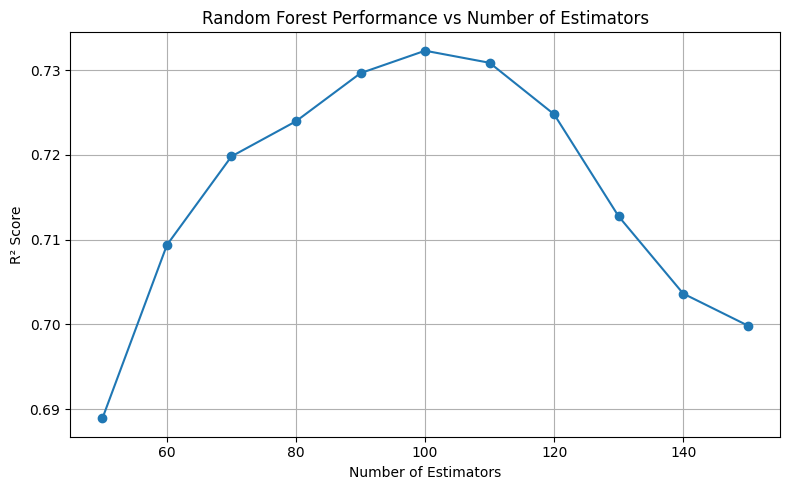

In [120]:
# Define range of number of estimators
n_estimators_range = range(50, 151, 10)  # From 1 to 150 in steps of 10
r2_scores = []

# Train Random Forest with different numbers of estimators
for n in n_estimators_range:
    model = RandomForestRegressor(n_estimators=n, random_state=42)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    r2_scores.append(r2_score(y_test, y_pred))

# Plot R² score vs number of estimators
plt.figure(figsize=(8, 5))
plt.plot(n_estimators_range, r2_scores, marker='o')
plt.title("Random Forest Performance vs Number of Estimators")
plt.xlabel("Number of Estimators")
plt.ylabel("R² Score")
plt.grid(True)
plt.tight_layout()
plt.savefig('rftree_estimator.png')
plt.show()


In [121]:
from sklearn.model_selection import LeaveOneOut

# Initialize LOOCV
loo = LeaveOneOut()

# Store predictions and true values
y_true_dt, y_pred_dt = [], []
y_true_rf, y_pred_rf = [], []

# Loop through LOOCV splits
for train_idx, test_idx in loo.split(x):
    x_train_cv, x_test_cv = x.iloc[train_idx], x.iloc[test_idx]
    y_train_cv, y_test_cv = y.iloc[train_idx], y.iloc[test_idx]
    
    # Decision Tree (reuse your best or default config)
    dtree.fit(x_train_cv, y_train_cv)
    y_pred_dt.append(dtree.predict(x_test_cv)[0])
    y_true_dt.append(y_test_cv.values[0])

    # Random Forest
    rf_model.fit(x_train_cv, y_train_cv)
    y_pred_rf.append(rf_model.predict(x_test_cv)[0])
    y_true_rf.append(y_test_cv.values[0])

# Evaluate Decision Tree
print("Decision Tree LOOCV:")
print("  MSE:", mean_squared_error(y_true_dt, y_pred_dt))
print("  R² :", r2_score(y_true_dt, y_pred_dt))

# Evaluate Random Forest
print("\nRandom Forest LOOCV:")
print("  MSE:", mean_squared_error(y_true_rf, y_pred_rf))
print("  R² :", r2_score(y_true_rf, y_pred_rf))


Decision Tree LOOCV:
  MSE: 356308.2760742976
  R² : 0.4013819972921143

Random Forest LOOCV:
  MSE: 224746.5891189947
  R² : 0.6224130526068143


### XGBoost

In [122]:
pip install xgboost


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [123]:
import xgboost as xgb



In [124]:
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
xgb_model.fit(x_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [125]:
y_pred = xgb_model.predict(x_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.2f}")
print(f"R² Score: {r2:.2f}")


Mean Squared Error: 216388.44
R² Score: 0.78


In [126]:
#use PCA data
xgb_pca_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
xgb_pca_model.fit(x_pca_train, y_pca_train)


y_pred = xgb_pca_model.predict(x_pca_test)

mse = mean_squared_error(y_pca_test, y_pred)
r2 = r2_score(y_pca_test, y_pred)

print(f"Mean Squared Error: {mse:.2f}")
print(f"R² Score: {r2:.2f}")


Mean Squared Error: 277392.59
R² Score: 0.71


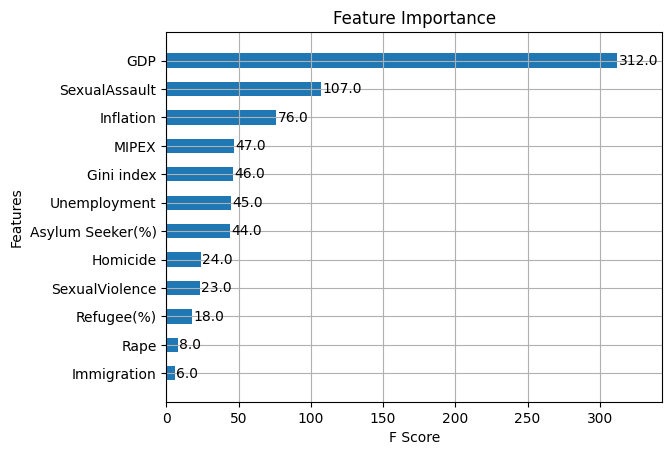

In [127]:
from xgboost import plot_importance

# Plot feature importance with desired styling
plot_importance(xgb_model, height=0.5, title="Feature Importance", xlabel="F Score")

# Save the plot to a file
plt.savefig('xgb_feature_importance.png', bbox_inches='tight')

# Display the plot
plt.show()

Hyperparameter Tuning

In [128]:
from sklearn.model_selection import RandomizedSearchCV

param_dist = {
    'n_estimators': [ 90, 100, 110],
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    # 'subsample': [0.6, 0.8, 1.0],
    # 'colsample_bytree': [0.6, 0.8, 1.0],
    # 'gamma': [0, 0.1, 0.3, 0.5]
}

# 4) Run RandomizedSearchCV
search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=50,              # number of sampled combinations
    scoring='r2',
    cv=5,
    random_state=42,
    n_jobs=-1
)
search.fit(x_train, y_train)

# 5) Evaluate best model
best = search.best_estimator_
y_pred = best.predict(x_test)

print("Best parameters:", search.best_params_)
print(f"Mean Squared Error: {mean_squared_error(y_test, y_pred):.2f}")
print(f"R² Score: {r2_score(y_test, y_pred):.2f}")

c:\Users\SILA\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:305: UserWarning: The total space of parameters 48 is smaller than n_iter=50. Running 48 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best parameters: {'n_estimators': 90, 'max_depth': 7, 'learning_rate': 0.2}
Mean Squared Error: 195479.79
R² Score: 0.80


## k-NN

In [129]:
from sklearn.neighbors import KNeighborsRegressor

Since k-NN is a distance based model, we need to scale the data.

In [130]:
# 2. Fit scaler on training data, transform both train & test
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled  = scaler.transform(x_test)

In [131]:
knn = KNeighborsRegressor(n_neighbors=3)
knn.fit(x_train_scaled, y_train)

# 4. Evaluate
y_pred = knn.predict(x_test_scaled)
print(f"MSE: {mean_squared_error(y_test, y_pred):.2f}")
print(f"R²:  {r2_score(y_test, y_pred):.2f}")

MSE: 376288.51
R²:  0.61


k=1 → R²: 0.2402
k=2 → R²: 0.3250
k=3 → R²: 0.6088
k=4 → R²: 0.5879
k=5 → R²: 0.5990


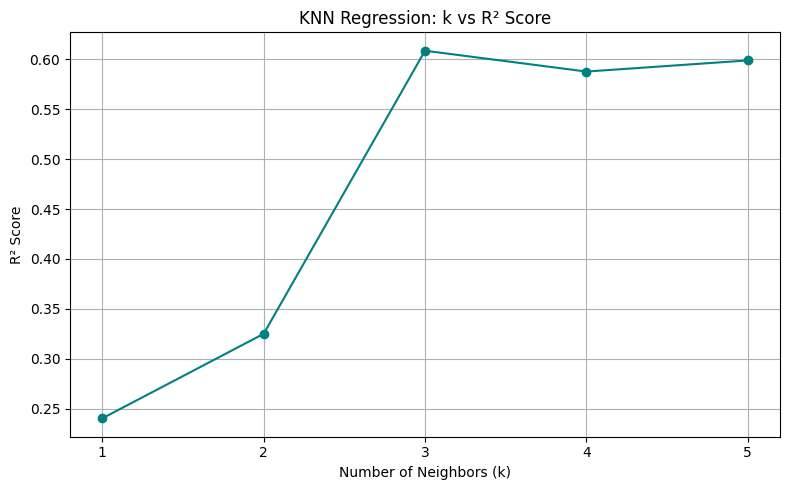

In [132]:
# Store results
k_values = list(range(1, 6))
r2_scores = []

# Try different k values
for k in k_values:
    knn = KNeighborsRegressor(n_neighbors=k)
    knn.fit(x_train_scaled, y_train)
    y_pred = knn.predict(x_test_scaled)
    r2 = r2_score(y_test, y_pred)
    r2_scores.append(r2)
    print(f"k={k} → R²: {r2:.4f}")

# Plotting
plt.figure(figsize=(8, 5))
plt.plot(k_values, r2_scores, marker='o', linestyle='-', color='teal')
plt.title("KNN Regression: k vs R² Score")
plt.xlabel("Number of Neighbors (k)")
plt.ylabel("R² Score")
plt.xticks(k_values)
plt.grid(True)
plt.tight_layout()
plt.savefig('kNN.png')
plt.show()
